In [1]:
# Author: Riley Owens (GitHub: mrileyowens)

# This file measures values and errors of 
# various Lyα profile parameters.

In [2]:
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=100
plt.rcParams['lines.linewidth']=0.5
from matplotlib.offsetbox import AnchoredText

from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from scipy.integrate import quad
from scipy.interpolate import interp1d

from lmfit.models import SkewedGaussianModel

In [3]:
def gaussFit(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def integrand(t):
    return np.exp(-1.0*(t**2)/2.0)

def skewGaussFit(x,a,x0,sigma,skew,cntm):
    return a*np.exp(-1.0*(((x0-x)/sigma)**2)/2.0)*quad(integrand,-np.inf,skew*(x0-x)/sigma)+cntm

def fitSkewPeak2(x,y,b1,b2,params,bounds):
    
    y=y[x > b1]
    x=x[x > b1]
    y=y[x < b2]
    x=x[x < b2]
    
    popt,pcov=curve_fit(skewGaussFit,x,y,p0=params,bounds=bounds)
    
def fitNormPeak(vArr,fArr,sampleMin,sampleMax,params,bounds):
    
    fArr=fArr[vArr > sampleMin]
    vArr=vArr[vArr > sampleMin]
    fArr=fArr[vArr < sampleMax]
    vArr=vArr[vArr < sampleMax]
    
    popt,pcov=curve_fit(gaussFit,vArr,fArr,p0=params,bounds=bounds)
    
    return popt,pcov

def fitSkewPeak(x,y,b1,b2):

    y=y[x > b1]
    x=x[x > b1]
    y=y[x < b2]
    x=x[x < b2]

    mod=SkewedGaussianModel()
    
    print(mod.param_names)
    
    pars=mod.make_params(amplitude=np.max(y),center=np.mean(x),sigma=30.0,gamma=-1.0)

    #pars=mod.guess(y, x=x)
    out=mod.fit(y, pars, x=x)
    
    print(out.fit_report())
    
    return x,out.best_fit

#def centroid(vArr,fArr,Min,Max):
    
#    mask=((vArr>Min) & (vArr<Max)).astype(int)
#    fArrMask=fArr*mask
#    i=np.argmax(fArrMask)
#    a1=(fArrMask[i+1]-fArrMask[i-1])/2
#    a2=(fArrMask[i+1]+fArrMask[i-1]-2*fArrMask[i])/2
    
#    ctrPix=i-(a1/(2*a2))
    
#    ctr=((vArr[-1]-vArr[-2])*(ctrPix-i))+vArr[i]
    
#    return ctr

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y, Min, Max,ctr):
    
    y=np.where(x>Min,y,0.0)
    y=np.where(x<Max,y,0.0)
    
    f=interp1d(x,y)
    peak=f(ctr)
    
    half = peak/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)],half

def v2w(v,redshift):
    
    w=1215.67*(1.0+redshift)*(1.0+(v/3e5))
    
    return w

def cont(wArr,fArr,Min,Max):
    
    fArr=fArr[wArr > Min]
    wArr=wArr[wArr > Min]
    fArr=fArr[wArr < Max]
    wArr=wArr[wArr < Max]
    
    cont=np.mean(fArr)
    
    return cont

def bounds(x,y,cont,b1,b2,m,n):
    
    #y=np.where(x>=b2,y,0.0)
    #y=np.where(x<=b1,y,0.0)
    
    #print(y)
    
    y=y[x > b1]
    x=x[x > b1]
    y=y[x < b2]
    x=x[x < b2]
    
    signs=np.sign(np.add(y, -cont))
    zero_crossings=(signs[0:-2] != signs[1:-1])
    zero_crossings_i=np.where(zero_crossings)[0]
    
    return [lin_interp(x, y, zero_crossings_i[m], cont),
            lin_interp(x, y, zero_crossings_i[n], cont)]

def peaks(x,y,x0,sigma,slit):
    
    y=y[(x >= -1000.0) & (x <= 1000.0)]
    x=x[(x >= -1000.0) & (x <= 1000.0)]
    
    signs=np.sign(y)
    zero_crossings=(signs[0:-2] != signs[1:-1])
    zero_crossings_i=np.where(zero_crossings)[0]
    
    xZeros=np.take(x,zero_crossings_i)
    yZeros=np.take(y,zero_crossings_i)
    
    intp=np.array([])
    
    for i in zero_crossings_i:
        
        n=lin_interp(x,y,i,0.0)
        
        intp=np.append(intp,n)
    
    rZeros=zero_crossings_i[(xZeros >= 175.0) & (xZeros <= 1000.0)]
    
    bZeros=zero_crossings_i[(xZeros <= -10.0) & (xZeros >= -1000.0)]
    
    #rPeak=intp[xZeros >= 175.0][0]
    #bPeak=intp[intp <= -10.0][-1]
    
    #print(intp)
    
    if slit=='H6':
        
        bP=np.mean(intp[(intp >= -200.0) & (intp <= 0.0)])
        rP=np.mean(intp[(intp >= x0+1.5*sigma) & (intp <= 320.0)])
        
    elif slit=='H3':
        
        bP=np.mean(intp[(intp >= -200.0) & (intp <= -10.0)])
        rP=np.mean(intp[(intp >= 200.0) & (intp <= 320.0)])
    
    else:
    
        bP=np.mean(intp[(intp >= -200.0) & (intp <= x0-1.5*sigma)])
        rP=np.mean(intp[(intp >= x0+1.5*sigma) & (intp <= 320.0)])
        
        #print(x0+1.5*sigma)
    
    #print(bP,rP)
    
    return bP,rP

#def ewbds(x,y,cont,w):
    
#    signs = np.sign(np.add(y, -cont))
#    zero_crossings = (signs[0:-2] != signs[1:-1])
#    zero_crossings_i = np.where(zero_crossings)[0]
#    wZeros=np.take(x,zero_crossings_i)
#    b1=wZeros[wZeros <= w][-1]
#    b2=wZeros[wZeros >= w][0]
    
#    return [lin_interp(x, y, zero_crossings_i[0], cont),
#            lin_interp(x, y, zero_crossings_i[1], cont)],b1,b2

def ewfluxlum(wArr,fArr,cont,z):
    
    Min=1212.0*(z+1.0)
    Max=1221.0*(z+1.0)
    
    fArr=fArr[wArr > Min]
    wArr=wArr[wArr > Min]
    fArr=fArr[wArr < Max]
    wArr=wArr[wArr < Max]
    
    flux=np.trapz(fArr-cont,wArr)
    lum=4*np.pi*flux*((((2.998e10)*z)/(2.26830849e-18))**2)
    ew=abs(np.trapz(1.0-np.divide(fArr,cont),wArr))
    
    
    return ew,flux,lum

In [4]:
# Establishing directories and filepaths
home='C://Users/15136/OneDrive - University of Cincinnati/Documents/Research/sunburstarc'
data=home+'/data/spectra/mage'
figs=home+'/figs'

In [5]:
# Declaring plot labels
wlabel='Wavelength (Å)'
vlabel='Velocity (km s$^{-1}$)'
flabel='Flux (10$^{-16}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)'

In [6]:
df=pd.read_csv(data+'/slits.txt',delimiter=' ',header=0)

# String array containing slit names
slits=df.iloc[:,0].to_numpy(dtype=str)
files=df.iloc[:,1].to_numpy(dtype=str)
z=df.iloc[:,2].to_numpy(dtype=np.float64)

ampGuess=df.iloc[:,3].to_numpy()
ctrGuess=df.iloc[:,4].to_numpy()
stdGuess=df.iloc[:,5].to_numpy()

Min=df.iloc[:,6].to_numpy(dtype=np.float64)
Max=df.iloc[:,7].to_numpy(dtype=np.float64)

ctrLBnd=df.iloc[:,8].to_numpy(dtype=np.float64)
stdLBnd=df.iloc[:,9].to_numpy(dtype=np.float64)
ctrUBnd=df.iloc[:,10].to_numpy(dtype=np.float64)
stdUBnd=df.iloc[:,11].to_numpy(dtype=np.float64)

contLBnd=df.iloc[:,12].to_numpy(dtype=np.float64)
contUBnd=df.iloc[:,13].to_numpy(dtype=np.float64)

# Boolean arrays which indicate if clump has central
# or blue peaks in Lyα profile
cPeak=df.iloc[:,14].to_numpy(dtype=bool)
bPeak=df.iloc[:,15].to_numpy(dtype=bool)

# Boolean array which indicates if clump leaks LyC
lyc=df.iloc[:,16].to_numpy(dtype=bool)

c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[119.36217515887078, 365.9048853830819]
[153.0557696971511, 368.2343258228091]
[133.26128151291982, 356.4837782979225]
[132.09007370000185, 364.2003400322856]
[162.45731836441507, 406.6566443808688]
[138.66513501869073, 388.49894461194276]
[107.72723682773643, 385.6397939379325]
[117.70898544444827, 396.37490412891833]
[136.02413090108982, 406.19202044388055]
[167.41324916135565, 422.1067378663196]
[138.36939939564286, 357.9192572711055]
[129.16783777757962, 367.484406107615]
[136.90478040461383, 353.6640813075235]
[125.28067906632326, 372.90426828478604]
[119.44357570770383, 363.92458975797456]
[143.27816587866567, 386.71581446661565]
[127.17815027611293, 398.11989983366027]
[113.89193738660282, 423.65616800884993]
[118.38778183380738, 350.11593520749534]
[122.86855802870245, 408.0674245461617]
[137.21138096729726, 400.21976250393107]
[115.60072167546463, 383.0999685493418]
[136.47875616885764, 357.4545417986361]
[127.13131917597877, 404.7680351212356]
[99.39254389836753, 403.54020122

c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[138.4883469823967, 400.5083670827668]
[131.44262716537617, 393.0184112299441]
[145.4410333409085, 422.0086823172425]
[109.33909181581949, 386.80758067510715]
[134.70433672293086, 365.7318628200595]
[123.80330224694723, 348.88436927591886]
[121.73885358095424, 364.0360674428253]
[118.54361033854933, 373.51915324758096]
[116.20933367322955, 359.73967007141266]
[171.01967710887814, 438.2001748316157]
[152.90583583703983, 392.99343106913733]
[210.29512879388753, 409.5337857066188]
[111.74935870695214, 369.89316010414893]
[113.72476465329055, 415.62196949014736]
[147.88167091497132, 408.55420024639795]
[114.88922427957696, 406.86845895028137]
[109.08550312050795, 409.7856227070514]
[112.37066754625094, 386.76259163228667]
[133.8375507496873, 360.44562661618806]
[127.39347215156312, 373.1122783990786]
[186.88701205877194, 472.8446656753198]
[140.99516878482714, 359.21730163942414]
[121.2846933553381, 409.2586891388778]
[160.03044555635094, 387.40288633115597]
[127.84200585954528, 406.757490

[105.10704252807096, 402.5923894991178]
[115.22820439833828, 434.29806436585477]
[131.5694953128788, 344.5640666182087]
[113.40391804779146, 390.948237600097]
[125.82159064215291, 372.74713083484386]
[121.59395523221504, 357.6092374911818]
[115.936144421085, 426.9274201301071]
[116.34438067030298, 395.1381783787367]
[134.00843478426933, 357.9371401362897]
[126.4399485200969, 398.50269134158805]
[115.03776620541925, 422.05789397544004]
[152.10067787348916, 395.41699095678604]
[100.89998625731447, 402.72048562315626]
[125.42684342111974, 389.27415944147674]
[130.27778560000962, 358.43665224304976]
[112.70704065564638, 407.8921747107712]
[135.74115380992353, 411.4800692921949]
[122.53716955204173, 363.944826245719]
[122.07582372165648, 346.79602303966914]
[117.90396526280207, 393.26827998917526]
[120.61151425793906, 346.08967254112935]
[124.5038921787212, 409.4453380807079]
[121.2531648186279, 403.7375860874059]
[124.36286406837931, 342.13911617891495]
[115.87834888247741, 412.52728091889

c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\scipy\interpolate\interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
c:\users\15136\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sign


[141.07447873039865, 362.7310816791044]
[131.13164110469762, 376.5283695529268]
[128.64814911069618, 359.84115447046514]
[102.37783969548599, 426.6943406917137]
[128.15160053181702, 390.63926961792095]
[127.96723684760097, 385.82700355010496]
[130.38307632932245, 351.81860754925725]
[126.58174854848977, 360.56819178569435]
[156.35694737495348, 389.2843732827518]
[115.08244369142595, 399.46913000263777]
[136.37390291093595, 364.03108419263543]
[144.01146103994057, 360.61279086728223]
[135.10443588089865, 344.4212177643458]
[114.92521917643171, 392.13359293725046]
[125.44462066309099, 390.3731960651191]
[115.25010778590008, 387.4080083662045]
[125.34358535718118, 357.35464401469574]
[123.88940236062997, 377.3780040606591]
[154.39609847923546, 377.09582543822324]
[111.78407166683243, 401.09042391856735]
[119.17694670152773, 397.54384710762844]
[131.14043943085335, 404.28745301194505]
[123.66108997771757, 374.52718358514863]
[105.32613375554232, 406.0288455830428]
[119.95651918707254, 382.

[110.1867547960669, 385.8322027674837]
[206.29304200942778, 408.4283522114933]
[125.51045835332319, 404.4607770238301]
[125.10924125027638, 380.5210654901191]
[121.96508394915561, 370.2716555563583]
[120.39324229775514, 402.75066819306016]
[130.00774687216966, 345.84063582407947]
[120.07668605636287, 380.23158921513567]
[124.64448616189324, 361.98498800358703]
[130.2415877848382, 403.56959952276367]
[122.71175631152713, 381.5627507960873]
[138.8617999186796, 373.3724255812049]
[121.3670629911718, 388.5379161911733]
[168.07425883541248, 404.0242691431786]
[122.80605694958629, 368.7029622457573]
[140.49957094978976, 373.2365618295472]
[131.31536375427945, 395.93546994510893]
[110.7748474396868, 389.77231432017044]
[132.11164921884475, 394.02738857562997]
[117.23895184558522, 399.86371665372036]
[112.83058922831614, 411.2477226351414]
[136.76548814930706, 405.33306100908]
[123.88243916642367, 368.3616763706357]
[113.02030727401744, 363.5460464358237]
[127.07368600131362, 403.3161209384735

[126.90754246455117, 351.5515915437952]
[118.9715544433621, 366.0831702562431]
[136.81054503711343, 366.5228260056165]
[126.34952834082522, 389.474222118436]
[124.19004573440144, 395.7794793883055]
[143.00414448903953, 361.71167264899583]
[123.28890876091675, 363.56018428265173]
[125.74609996203472, 393.9867799501911]
[112.63813134397118, 389.8758585184903]
[122.65829082976816, 377.87032395881135]
[126.85215395086766, 406.6003313350169]
[132.16879018393348, 350.52174121385804]
[124.94704129190602, 362.1675741907807]
[132.19214818556216, 373.03444595482415]
[127.83016405530789, 367.33414309376656]
[121.56754814346341, 397.6842733120706]
[119.08494682467177, 397.71954228412807]
[108.86010580554247, 407.81047076377905]
[130.46301352205498, 395.2676550139997]
[118.63914728443078, 377.457348042076]
[120.47696928299023, 420.6987565251272]
[117.6616960628228, 383.65174338286863]
[124.5280833016919, 380.5388012334038]
[135.27016069621058, 377.58269224920923]
[126.2389230939473, 358.33722870124

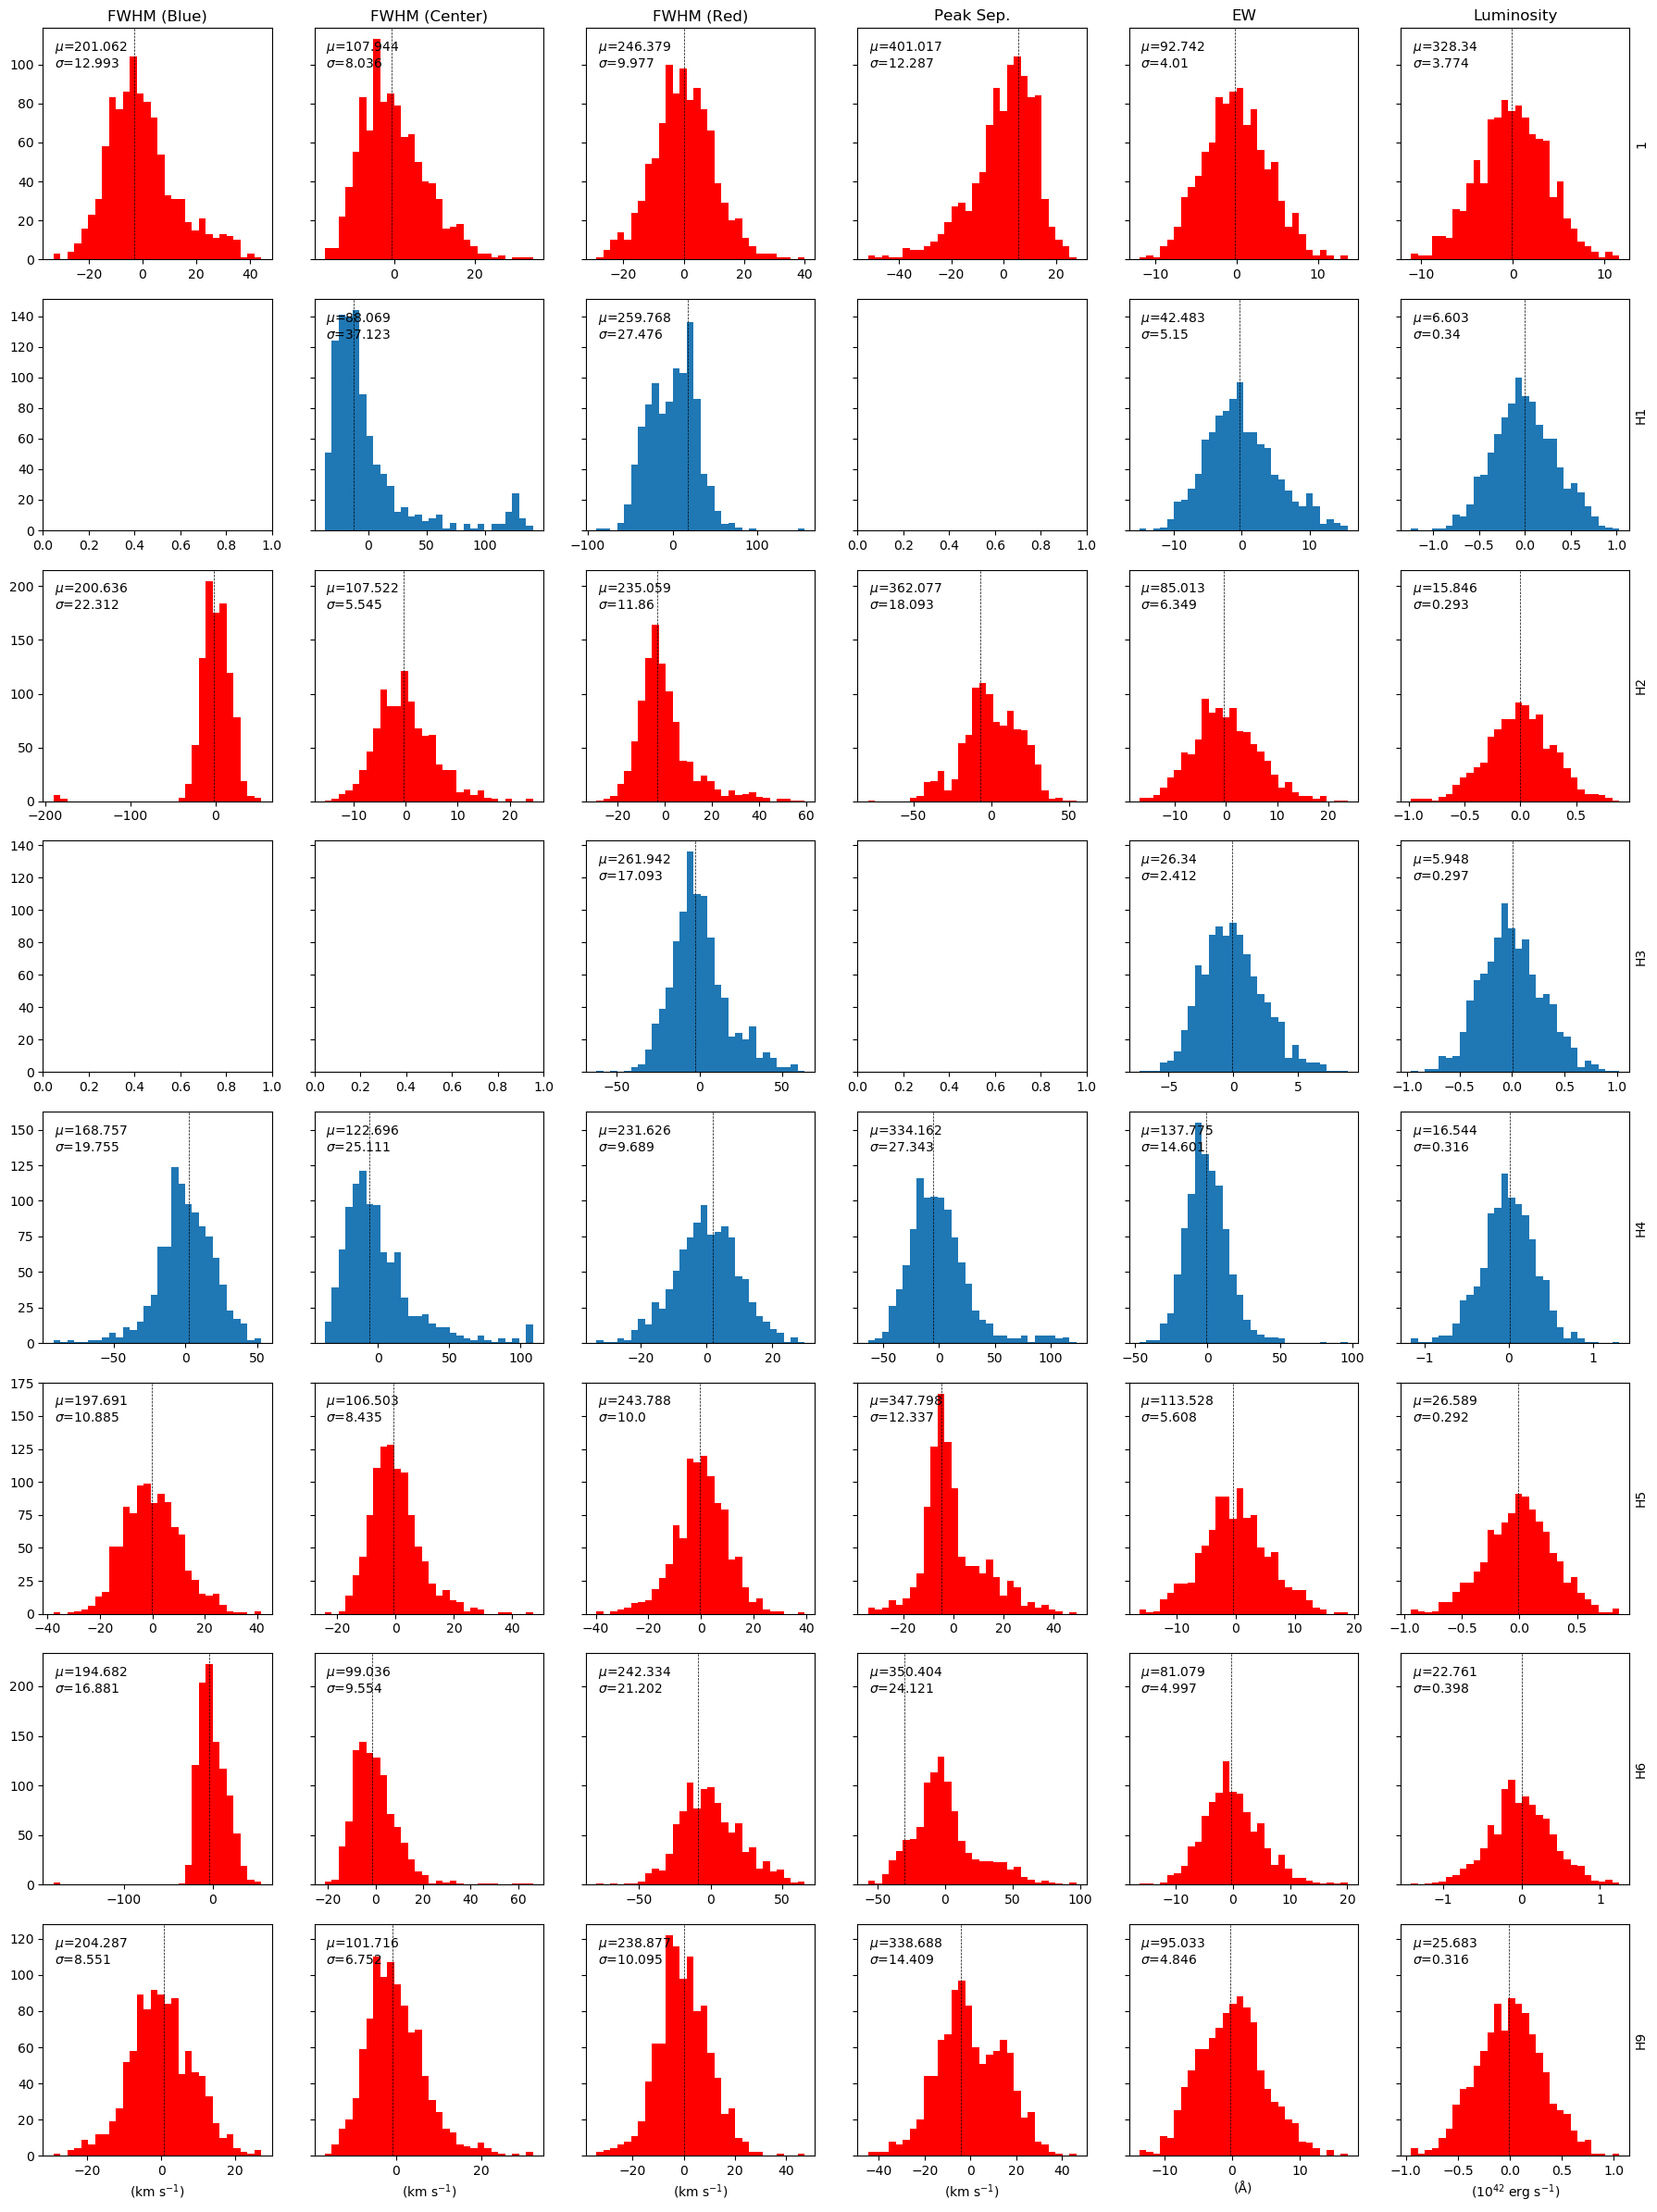

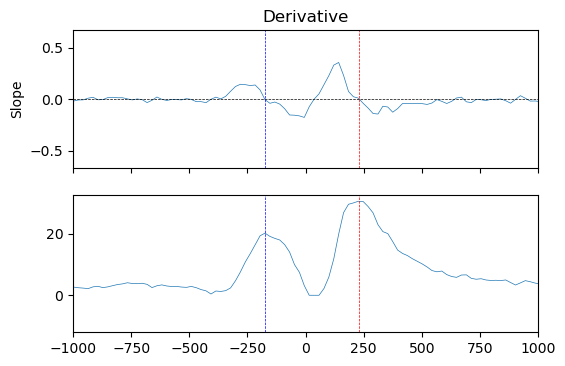

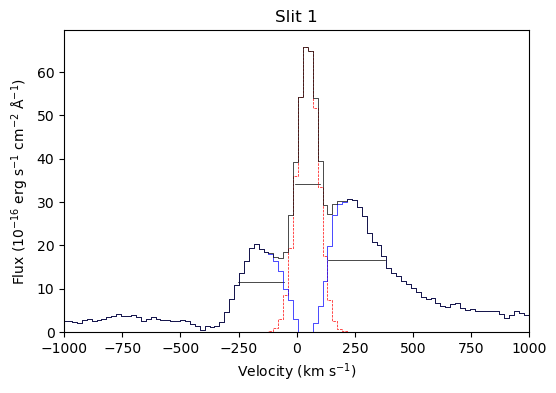

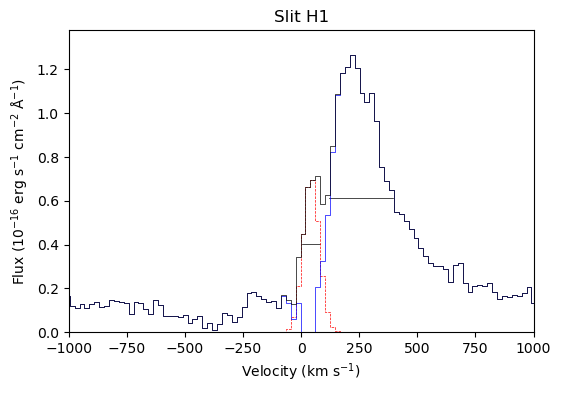

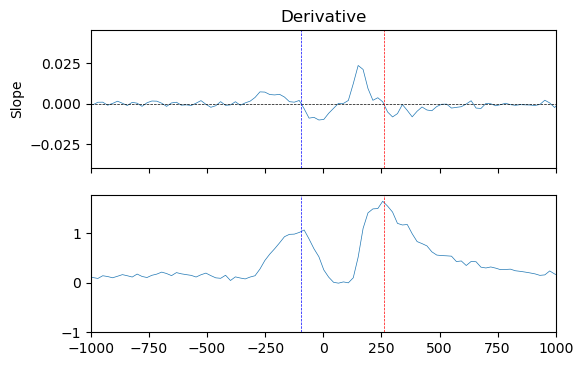

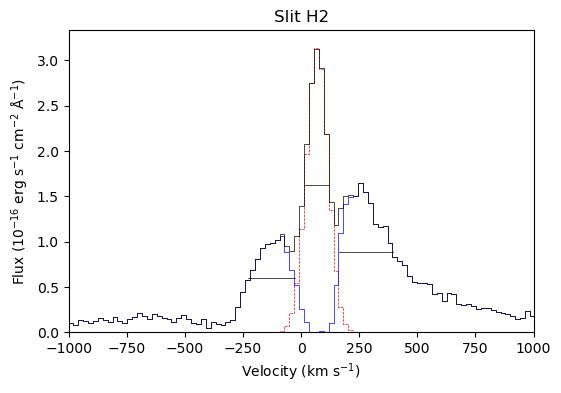

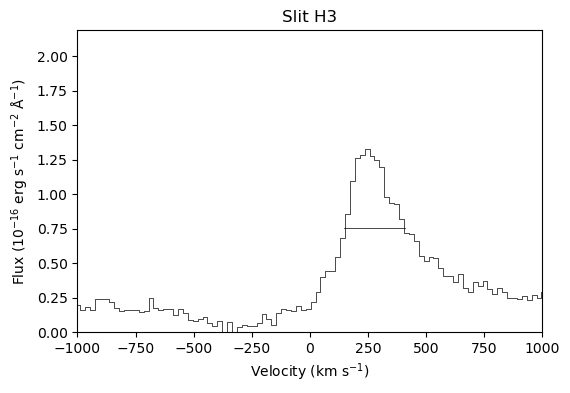

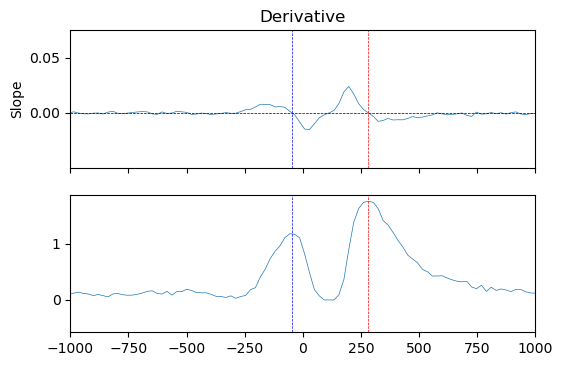

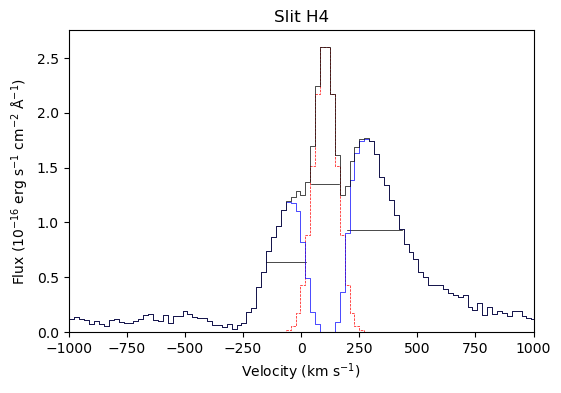

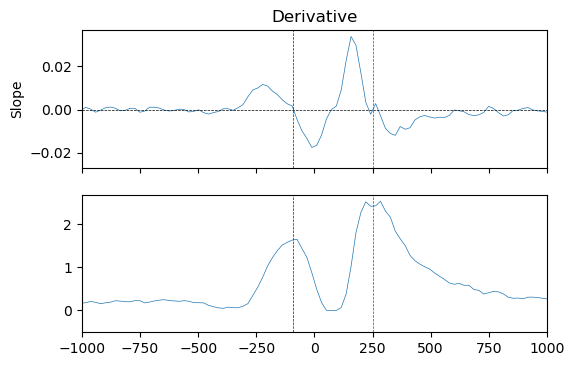

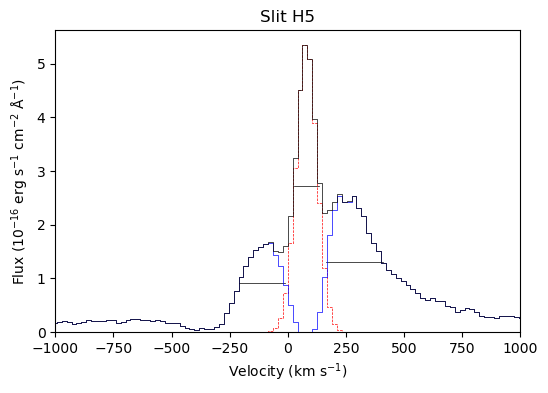

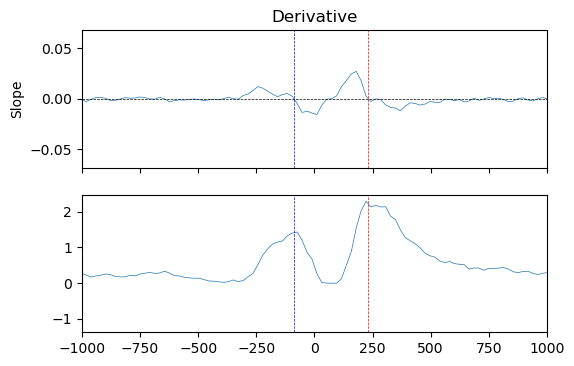

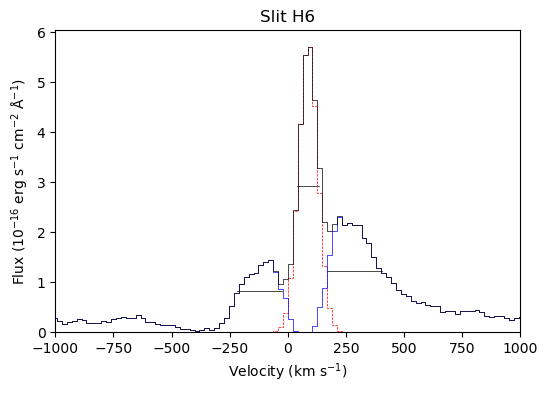

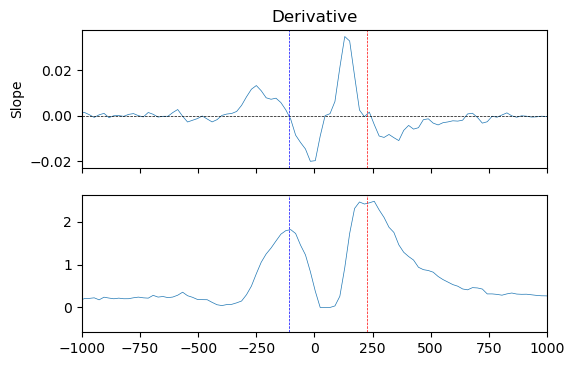

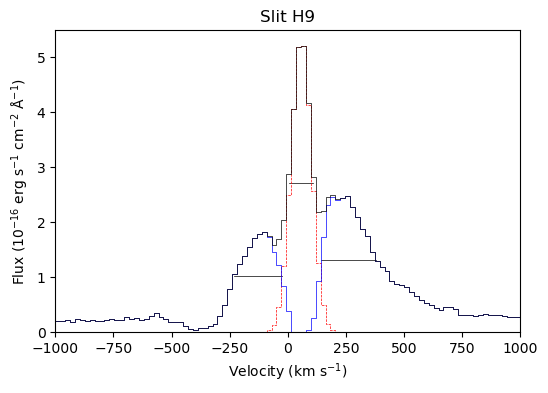

In [7]:
# Initializing figure of histograms of various line measurements
# after noise perturbation
figErr,axErr=plt.subplots(8,6,figsize=(18,24),sharey='row')

for i in np.indices(np.shape(slits)).flatten():
    
    #Converting .txt file into a data frame
    dataFrame=pd.read_csv(data+'/'+files[i],delimiter='\t',header=0,skiprows=13)

    #Discarding missing data
    dataFrame=dataFrame.apply(pd.to_numeric,errors='coerce').dropna()

    #Discarding extreme outliers
    dataFrame=dataFrame[dataFrame.iloc[:,1]<1e-20]

    #Resetting the index
    dataFrame=dataFrame.reset_index(drop=True)

    # Extracting wavelength, flux, and noise
    wArr=dataFrame.iloc[:,0].to_numpy()
    fArr=(dataFrame.iloc[:,1].to_numpy())*((2.998e18)/(np.square(wArr)))
    nArr=(dataFrame.iloc[:,2].to_numpy())*((2.998e18)/(np.square(wArr)))

    # Converting wavelength to peculiar velocity
    # of Lyman-α line
    vArr=(3e5)*(((wArr/(1+np.float64(z[i])))/1215.67)-1)
    
    w=1215.67*(z[i]+1)
    
    title='Slit '+slits[i]
    
    # If there is a blue and red peak
    if cPeak[i]==True & bPeak[i]==True:
        
        fitGuess=(ampGuess[i],ctrGuess[i],stdGuess[i])
        sampleRange=(Min[i],Max[i])
        
        # Fitting central peak
        popt,pcov=fitNormPeak(vArr,fArr*1e16,*sampleRange,params=fitGuess,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
        
        # Computing local continuum
        cntm=cont(wArr,fArr,contLBnd[i],contUBnd[i])
        
        # Computing EW, flux, luminosity of line profile
        e,f,l=ewfluxlum(wArr,fArr,cntm,z[i])
        l=l*1e-42
        
        bdsB=bounds(vArr,fArr*1e16-gaussFit(vArr,*popt),cntm*1e16,-2000.0,popt[1],-1,-2)
        bdsR=bounds(vArr,fArr*1e16-gaussFit(vArr,*popt),cntm*1e16,popt[1],2000.0,0,1)
        
        deriv=np.gradient(fArr*1e16-gaussFit(vArr,*popt),vArr,edge_order=2)
        
        b,r=peaks(vArr,deriv,popt[1],popt[2],slits[i])
        
        hmxB,halfB=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm*1e16,-750.0,popt[1],b)
        hmxR,halfR=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm*1e16,popt[1],750.0,r)
        hmxC,halfC=half_max_x(vArr,gaussFit(vArr,*popt)-cntm*1e16,-1000.0,1000.0,popt[1])
        
        fig1,ax1=plt.subplots(2,1,sharex=True)
        
        ax1[0].plot(vArr,deriv)
        ax1[0].axhline(0.0,ls='dashed',c='black')
        ax1[0].axvline(b,ls='dashed',c='blue')
        ax1[0].axvline(r,ls='dashed',c='red')
        
        ax1[0].set_xlim(-1000.0,1000.0)
        
        ax1[0].set_ylabel('Slope')
        ax1[0].set_title('Derivative')
        
        ax1[1].plot(vArr,fArr*1e16-gaussFit(vArr,*popt))
        ax1[1].axvline(b,ls='dashed',c='blue')
        ax1[1].axvline(r,ls='dashed',c='red')
        
        fig,ax=plt.subplots(1,1)

        plt.plot(hmxB, [halfB+cntm*1e16, halfB+cntm*1e16],c='black')
        plt.plot(hmxC,[halfC+cntm*1e16,halfC+cntm*1e16],c='black')
        plt.plot(hmxR, [halfR+cntm*1e16, halfR+cntm*1e16],c='black')
        
        plt.plot(vArr,gaussFit(vArr,*popt),ds='steps-mid',ls='dashed',c='red')
        
        plt.plot(vArr,fArr*1e16-gaussFit(vArr,*popt),ds='steps-mid',c='blue')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')
        
        #plt.plot(vArr,skewGaussFit(vArr,*popt2),c='red')
        
        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        n=0
        fwhmRArr=np.array([])
        fwhmCArr=np.array([])
        fwhmBArr=np.array([])
        psepArr=np.array([])
        ctrBArr=np.array([])
        ctrRArr=np.array([])
        ewArr=np.array([])
        lumArr=np.array([])
        
        # Repeating measurement 1000 times, adding Gaussian noise each time
        while n!=1000:
            
            # Adding Gaussian noise into measurement from 
            # reported noise
            smthg=np.random.normal(fArr,nArr)
        
            # Computing noise-perturbed local continuum
            cntmN=cont(wArr,smthg,contLBnd[i],contUBnd[i])
            
            # Computing noise=perturbed EW, flux, luminosity of line profile
            eN,fN,lN=ewfluxlum(wArr,smthg,cntmN,z[i])
            lN=lN*1e-42
    
            # Fitting noise-perturbed central peak
            popt1,pcov1=fitNormPeak(vArr,smthg*1e16,*sampleRange,params=popt,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
    
            peak=gaussFit(vArr,*popt1)
            noCPeak=smthg*1e16-gaussFit(vArr,*popt1)
    
            #ctrBN=centroid(vArr,smthg*1e16-gaussFit(vArr,*popt1),-250.0,popt1[1])
            #ctrRN=centroid(vArr,smthg*1e16-gaussFit(vArr,*popt1),popt1[1],500.0)
            
            # Computing noise-perturbed numerical derivative of flux
            derivN=np.gradient(smthg*1e16-gaussFit(vArr,*popt1),vArr,edge_order=2)
        
            bN,rN=peaks(vArr,derivN,popt1[1],popt1[2],slits[i])
    
            psepN=rN-bN
        
            if slits[i]=='X' and abs((r-b)-(rN-bN)) >= 30.0:
        
                f,a=plt.subplots(2,1,sharex=True)
            
                a[0].plot(vArr,derivN)
                a[0].axvline(bN,ls='dashed',c='blue',label=str(bN))
                a[0].axvline(rN,ls='dashed',c='red',label=str(rN))
                a[0].axhline(0.0,ls='dashed',c='black')
                
                a[0].legend(loc='upper right')
            
                a[1].plot(vArr,smthg*1e16-gaussFit(vArr,*popt1))
                a[1].axvline(bN,ls='dashed',c='blue')
                a[1].axvline(rN,ls='dashed',c='red')
                a[1].axvline(b,ls='dotted',c='blue')
                a[1].axvline(r,ls='dotted',c='red')
            
                a[1].set_xlim(-1000.0,1000.0)
            
                plt.show()
    
            hmxRN,halfRN=half_max_x(vArr,noCPeak-cntmN*1e16,popt1[1],750.0,rN)
            hmxCN,halfCN=half_max_x(vArr,peak-cntmN*1e16,-1000.0,1000.0,popt1[1])
            hmxBN,halfBN=half_max_x(vArr,noCPeak-cntmN*1e16,-750.0,popt1[1],bN)
            
            #plt.plot(vArr,smthg*1e16-gaussFit(vArr,*popt1),c='blue',ds='steps-mid')
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,gaussFit(vArr,*popt1),ls='dashed',c='red',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntmN,halfRN+cntmN],c='black')
            #plt.plot(hmxCN,[halfCN+cntmN,halfCN+cntmN],c='black')
            #plt.plot(hmxBN,[halfBN+cntmN,halfBN+cntmN],c='black')
            #plt.axvline(ctrRN,ls='-')
            #plt.axvline(ctrBN,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
            
            #plt.plot(wArr,smthg,ds='steps-mid',c='black')
            #plt.axvline(b1N)
            #plt.axvline(b2N)
            #plt.xlim(w-20.0,w+20.0)
            #plt.title(slits[i])
            #plt.show()
    
            #print(*popt1)
    
            fwhmRN=np.array([hmxRN[1]-hmxRN[0]])
            fwhmCN=np.array([hmxCN[1]-hmxCN[0]])
            fwhmBN=np.array([hmxBN[1]-hmxBN[0]])
    
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            fwhmCArr=np.append(fwhmCArr,fwhmCN)
            fwhmBArr=np.append(fwhmBArr,fwhmBN)
            psepArr=np.append(psepArr,psepN)
            
            ewArr=np.append(ewArr,eN)
            lumArr=np.append(lumArr,lN)
    
            n=n+1
        
        # Assigning different color to 
        # LyC-leaking clumps
        if lyc[i]==True:
            clr='red'
        else:
            clr=None

        # Plotting histogram distributions of noise-perturbed profile measurements
        # compared to measured value from 'true' profile
        axErr[i,0].hist((fwhmBArr-np.mean(fwhmBArr)),bins=30,color=clr)
        axErr[i,0].axvline(((hmxB[1]-hmxB[0])-np.mean(fwhmBArr)),ls='dashed',c='black')
        
        axErr[i,1].hist((fwhmCArr-np.mean(fwhmCArr)),bins=30,color=clr)
        axErr[i,1].axvline(((hmxC[1]-hmxC[0])-np.mean(fwhmCArr)),ls='dashed',c='black')
        
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30,color=clr)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')

        axErr[i,3].hist((psepArr-np.mean(psepArr)),bins=30,color=clr)
        axErr[i,3].axvline(((r-b)-np.mean(psepArr)),ls='dashed',c='black')
        
        axErr[i,4].hist((ewArr-np.mean(ewArr)),bins=30,color=clr)
        axErr[i,4].axvline((e-np.mean(ewArr)),ls='dashed',c='black')
            
        axErr[i,5].hist((lumArr-np.mean(lumArr)),bins=30,color=clr)
        axErr[i,5].axvline((l-np.mean(lumArr)),ls='dashed',c='black')
        
        # Labeling columns
        if i==7:
            axErr[i,0].set_xlabel('(km s$^{-1}$)')
            axErr[i,1].set_xlabel('(km s$^{-1}$)')
            axErr[i,2].set_xlabel('(km s$^{-1}$)')
            axErr[i,3].set_xlabel('(km s$^{-1}$)')
            axErr[i,4].set_xlabel('(Å)')
            axErr[i,5].set_xlabel('(10$^{42}$ erg s$^{-1}$)')
        
        # Titling columns    
        if i==0:
            axErr[i,0].set_title('FWHM (Blue)')
            axErr[i,1].set_title('FWHM (Center)')
            axErr[i,2].set_title('FWHM (Red)')
            axErr[i,3].set_title('Peak Sep.')
            axErr[i,4].set_title('EW')
            axErr[i,5].set_title('Luminosity')
        
        # Labeling row with slit name
        axErr[i,5].yaxis.set_label_position("right")
        axErr[i,5].set_ylabel(slits[i])
        
        k=0
        
        for j in [fwhmBArr,fwhmCArr,fwhmRArr,psepArr,ewArr,lumArr]:
            
            at=AnchoredText('$\mu$='+str(round(np.mean(j),3))+'\n'+'$\sigma$='+str(round(np.std(j),3)),loc='upper left',frameon=False)
            
            axErr[i,k].add_artist(at)
            
            k=k+1
    
    # If there is a center peak and a red peak, 
    # but no blue peak
    elif cPeak[i]==True and bPeak[i]==False:
        
        fitGuess=(ampGuess[i],ctrGuess[i],stdGuess[i])
        sampleRange=(Min[i],Max[i])
        popt,pcov=fitNormPeak(vArr,fArr*1e16,*sampleRange,params=fitGuess,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
        
        #ctrR=centroid(vArr,fArr*1e16-gaussFit(vArr,*popt),popt[1],500.0)
        
        cntm=cont(wArr,fArr,contLBnd[i],contUBnd[i])
        
        e,f,l=ewfluxlum(wArr,fArr,cntm,z[i])
        l=l*1e-42
        
        deriv=np.gradient(fArr*1e16-gaussFit(vArr,*popt),vArr,edge_order=2)
        
        b,r=peaks(vArr,deriv,popt[1],popt[2],slits[i])
        
        hmxR,halfR=half_max_x(vArr,fArr*1e16-gaussFit(vArr,*popt)-cntm*1e16,popt[1],750.0,r)
        hmxC,halfC=half_max_x(vArr,gaussFit(vArr,*popt)-cntm*1e16,-1000.0,1000.0,popt[1])
        
        fig,ax=plt.subplots(1,1)
        
        #ax.axvline(ctrR,c='gray',ls='dotted')

        plt.plot(hmxC,[halfC+cntm*1e16,halfC+cntm*1e16],c='black')
        plt.plot(hmxR, [halfR+cntm*1e16, halfR+cntm*1e16],c='black')
        
        plt.plot(vArr,gaussFit(vArr,*popt),ds='steps-mid',ls='dashed',c='red')
        
        plt.plot(vArr,fArr*1e16-gaussFit(vArr,*popt),ds='steps-mid',c='blue')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')

        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        n=0
        fwhmRArr=np.array([])
        fwhmCArr=np.array([])
        fwhmBArr=np.array([])
        psepArr=np.array([])
        ewArr=np.array([])
        lumArr=np.array([])
        
        while n!=1000:
    
            smthg=np.random.normal(fArr,nArr)
        
            cntmN=cont(wArr,smthg,contLBnd[i],contUBnd[i])
            
            eN,fN,lN=ewfluxlum(wArr,smthg,cntmN,z[i])
            lN=lN*1e-42
    
            popt1,pcov1=fitNormPeak(vArr,smthg*1e16,*sampleRange,params=popt,bounds=([0.0,ctrLBnd[i],0.0],[np.inf,ctrUBnd[i],stdUBnd[i]]))
    
            peak=gaussFit(vArr,*popt1)
            noCPeak=smthg*1e16-gaussFit(vArr,*popt1)
            
            derivN=np.gradient(smthg*1e16-gaussFit(vArr,*popt1),vArr,edge_order=2)
            
            bN,rN=peaks(vArr,derivN,popt1[1],popt1[2],slits[i])
        
            hmxRN,halfRN=half_max_x(vArr,noCPeak-cntmN*1e16,popt1[1],1000.0,rN)
            hmxCN,halfCN=half_max_x(vArr,peak-cntmN*1e16,-1000.0,1000.0,popt1[1])
            
            print(hmxRN)

            #plt.plot(vArr,smthg*1e16-gaussFit(vArr,*popt1),c='blue',ds='steps-mid')
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,gaussFit(vArr,*popt1),ls='dashed',c='red',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntmN,halfRN+cntmN],c='black')
            #plt.plot(hmxCN,[halfCN+cntmN,halfCN+cntmN],c='black')
            #plt.axvline(ctrR,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
    
            #print(*popt1)
        
            if slits[i]=='X':
        
                f,a=plt.subplots(2,1,sharex=True)
            
                a[0].plot(vArr,derivN)
                a[0].axvline(bN,ls='dashed',c='blue',label=str(bN))
                a[0].axvline(rN,ls='dashed',c='red',label=str(rN))
                a[0].axhline(0.0,ls='dashed',c='black')
                
                a[0].legend(loc='upper right')
            
                a[1].plot(vArr,smthg*1e16-gaussFit(vArr,*popt1))
                a[1].axvline(bN,ls='dashed',c='blue')
                a[1].axvline(rN,ls='dashed',c='red')
                a[1].axvline(b,ls='dotted',c='blue')
                a[1].axvline(r,ls='dotted',c='red')
            
                a[1].set_xlim(-1000.0,1000.0)
            
                plt.show()
    
            fwhmRN=np.array([hmxRN[1]-hmxRN[0]])
            fwhmCN=np.array([hmxCN[1]-hmxCN[0]])
            
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            fwhmCArr=np.append(fwhmCArr,fwhmCN)
            
            ewArr=np.append(ewArr,eN)
            lumArr=np.append(lumArr,lN)
            
            n=n+1
            
        fwhmRArr=fwhmRArr[~np.isnan(fwhmRArr)]
        print(np.shape(fwhmRArr))

        axErr[i,1].hist((fwhmCArr-np.mean(fwhmCArr)),bins=30)
        axErr[i,1].axvline(((hmxC[1]-hmxC[0])-np.mean(fwhmCArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,1].set_title('FWHM (Center)')
            
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,2].set_title('FWHM (Red)')
        
        axErr[i,4].hist((ewArr-np.mean(ewArr)),bins=30)
        axErr[i,4].axvline((e-np.mean(ewArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,4].set_title('EW')
            
        axErr[i,5].hist((lumArr-np.mean(lumArr)),bins=30)
        axErr[i,5].axvline((l-np.mean(lumArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,5].set_title('Luminosity')
        
        axErr[i,5].yaxis.set_label_position("right")
        axErr[i,5].set_ylabel(slits[i])
        
        k=1
        
        for j in [fwhmCArr,fwhmRArr,ewArr,lumArr]:
            
            at=AnchoredText('$\mu$='+str(round(np.mean(j),3))+'\n'+'$\sigma$='+str(round(np.std(j),3)),loc='upper left',frameon=False)
            
            axErr[i,k].add_artist(at)
            
            if k==2:
                
                k=k+1
            
            k=k+1

    # If there is only a red peak
    elif cPeak[i]==False and bPeak[i]==False:
        
        cntm=cont(wArr,fArr,contLBnd[i],contUBnd[i])
        
        e,f,l=ewfluxlum(wArr,fArr,cntm,z[i])
        l=l*1e-42
        
        deriv=np.gradient(fArr*1e16,vArr,edge_order=2)
        
        b,r=peaks(vArr,deriv,popt1[1],popt1[2],slits[i])
        
        hmxR,halfR=half_max_x(vArr,fArr*1e16-cntm*1e16,0.0,750.0,r)
        
        fig,ax=plt.subplots(1,1)
        
        #ax.axvline(ctrR,c='gray',ls='dotted')

        plt.plot(hmxR, [halfR+cntm*1e16, halfR+cntm*1e16],c='black')
        
        plt.plot(vArr,fArr*1e16,ds='steps-mid',c='black')

        ax.set_xlim(-1000.0,1000.0)
        ax.set_ylim(0.0)
        plt.title(title)
        ax.set_xlabel(vlabel)
        ax.set_ylabel(flabel)
        
        plt.savefig(figs+'/'+slits[i]+'ctrfwhm.png',dpi=100,bbox_inches='tight')
        
        #plt.close('all')
        
        n=0
        fwhmRArr=np.array([])
        ewArr=np.array([])
        lumArr=np.array([])
        
        while n!=1000:
    
            smthg=np.random.normal(fArr,nArr)
        
            cntmN=cont(wArr,smthg,contLBnd[i],contUBnd[i])
            
            eN,fN,lN=ewfluxlum(wArr,smthg,cntmN,z[i])
            lN=lN*1e-42
            
            derivN=np.gradient(fArr*1e16,vArr,edge_order=2)
            
            bN,rN=peaks(vArr,derivN,popt1[1],popt1[2],slits[i])
    
            hmxRN,halfRN=half_max_x(vArr,smthg*1e16-cntmN*1e16,0.0,750.0,rN)
    
            #plt.plot(vArr,smthg*1e16,c='black',ds='steps-mid')
            #plt.plot(vArr,nArr*1e16,c='black',ds='steps-mid')
            #plt.plot(hmxRN,[halfRN+cntmN,halfRN+cntmN],c='black')
            #plt.axvline(ctrR,ls='-')
            #plt.xlim(-1000.0,1000.0)
            #plt.title(slits[i])
            #plt.show()
    
            fwhmRN=hmxRN[1]-hmxRN[0]
            
            fwhmRArr=np.append(fwhmRArr,fwhmRN)
            
            ewArr=np.append(ewArr,eN)
            lumArr=np.append(lumArr,lN)
            
            n=n+1
        
        axErr[i,2].hist((fwhmRArr-np.mean(fwhmRArr)),bins=30)
        axErr[i,2].axvline(((hmxR[1]-hmxR[0])-np.mean(fwhmRArr)),ls='dashed',c='black')
        
        axErr[i,4].hist((ewArr-np.mean(ewArr)),bins=30)
        axErr[i,4].axvline((e-np.mean(ewArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,4].set_title('EW')
            
        axErr[i,5].hist((lumArr-np.mean(lumArr)),bins=30)
        axErr[i,5].axvline((l-np.mean(lumArr)),ls='dashed',c='black')
        if i==0:
            axErr[i,5].set_title('Luminosity')
        
        axErr[i,5].yaxis.set_label_position("right")
        axErr[i,5].set_ylabel(slits[i])
        
        k=2
        
        for j in [fwhmRArr,ewArr,lumArr]:
            
            at=AnchoredText('$\mu$='+str(round(np.mean(j),3))+'\n'+'$\sigma$='+str(round(np.std(j),3)),loc='upper left',frameon=False)
            
            axErr[i,k].add_artist(at)
            
            if k==2:
                
                k=k+1
            
            k=k+1
            
#figErr.supxlabel('x-$\mu$')
#figErr.supylabel('Count')
        
figErr.tight_layout()

figErr.savefig(figs+'/err.png',dpi=100,bbox_inches='tight')

plt.show()